## Predicting Bike Rentals Using Random Forest
In this project, I am going to predict the total number of bikes people rent in a given hour. The dataset I will work on can be accessed from [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). In the project, I will also create some basic machine learning models to compare them with Random Forest.

### Read the dataset ###

In [3]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

In [4]:
bike_rentals  = pd.read_csv('hour.csv')

### Take a look at the data set

In [5]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
bike_rentals.tail()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


convet ```dteday``` to a column describing day. This is because, information of year and month is already included in other columns.

In [7]:
bike_rentals['dteday'] = bike_rentals['dteday'].str[-2:]
bike_rentals['dteday'] = bike_rentals['dteday'].astype(int)
bike_rentals = bike_rentals.rename({'dteday':'day'},axis=1)

In [8]:
bike_rentals.head()

,instant,day,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,1,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,1,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,1,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [9]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
day           17379 non-null int32
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int32(1), int64(12)
memory usage: 2.2 MB


It seems like that there is no missing values 

let's see a distribution of our target column

Text(0.5, 0, 'the number of rentals')

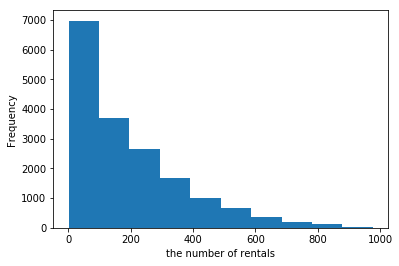

In [10]:
#make a histrogram
bike_rentals['cnt'].plot.hist()
plt.xlabel('the number of rentals')

(0, 1)

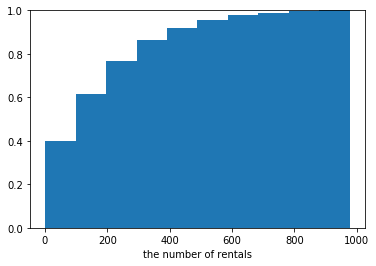

In [11]:
#make a cdf 
bike_rentals['cnt'].plot.hist(cumulative=True,normed=True)
plt.ylabel("")
plt.xlabel('the number of rentals')
plt.ylim((0,1))

In [12]:
#compute skewness
stats.skew(np.asarray(bike_rentals['cnt']))

1.2773013463494975

the distribution of ```cnt``` values is skewed to the right

let's see correlations between columns and ```cnt```

In [13]:
corr_with_cnt=bike_rentals.corr()['cnt']

In [14]:
corr_with_cnt

instant       0.278379
day          -0.004312
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

It does not seem like that there are columns very strongly related to ```cnt```. ```hr```,```temp```,```atemp```and,```hum``` seem to be corrlated with ```cnt```. ```casual``` and ```registered``` are very strongly correlated with ```cnt```, but their information is included in ```cnt```. Thus, the relationships are not really useful. 

I will add a new feature grouping values in ```hr``` into some categories. 
- 1 if the hour is from 6 to 12 
- 2 if the hour is from 12 to 18 
- 3 if the hour is from 18 to 24
- 4 if the hour is from 0 to 6

In [15]:
def mapper (x):
    if x in range(6,12):
        return 1
    elif x in range(12,18):
        return 2 
    elif x in range(18,24):
        return 3 
    else:
        return 4 

In [16]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(mapper)

In [17]:
bike_rentals.head(20)

,instant,day,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,4
1,2,1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,4
2,3,1,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,4
3,4,1,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,4
4,5,1,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,4
5,6,1,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1,4
6,7,1,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2,1
7,8,1,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3,1
8,9,1,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8,1
9,10,1,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14,1


## Splitting the data set 

Before splitting the data set, I would like to decide an error metric I'm gonna use. For this project, I will use MAE. This is because, although ```cnt``` column have some extreme values, correctly predicting them is not really important in my goal. Therefore, I think that I don't have to penalize a model more due to the existence of the values. 

In [18]:
# splitting data set 
train = bike_rentals.sample(frac=0.8,random_state=1)
test= bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Linear Regression Model

I will create a linear regression model. 

Before selecting features solely based on correlation between the target column and other columns, let's see if there are multicollinearity. 

### Select features 

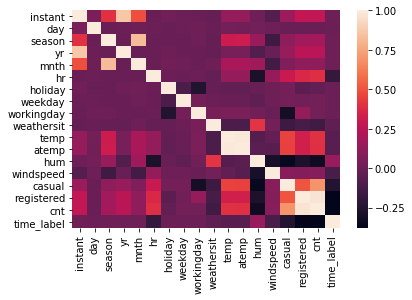

In [19]:
sns.heatmap(bike_rentals.corr())

- ```instant``` have strong correlations with ```season```,```yr```, and ```mnth```. (this is because of how the data set is constructed.)
- ```season``` is strongly correlated with ```mnth```. 
- ```temp``` is also highly correlated with ```atemp```

Therefore, I will drop ```instant``` ,```atemp```,and ```mnth``` because of multicollinearity if needed. 

In [20]:
#select columns with correlations higher than 0.3 in absolute form. 
columns_3 = corr_with_cnt[np.abs(corr_with_cnt) >= 0.3].index

In [21]:
columns_3

Index(['hr', 'temp', 'atemp', 'hum', 'casual', 'registered', 'cnt'], dtype='object')

Okay, finally, we will drop some columns from ```columns_3```. Let's drop ```atemp```,```casual```,and ```registered```. A reason for dropping ```casual``` and ```registered``` is that if we know them, it means that we also know ```cnt```. 

In [22]:
features = columns_3.drop(['atemp','casual','registered','cnt'])

In [23]:
features

Index(['hr', 'temp', 'hum'], dtype='object')

These three columns are used for our Linear Regression model

### train a model

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [25]:
lr = LinearRegression()
lr.fit(train[features],train['cnt'])
predictions = lr.predict(test[features])

In [26]:
#calculate the error metric for predictions on test data set
mean_absolute_error(test['cnt'],predictions)

106.62488018068693

In [27]:
#calculate the error metric for predictions on training data set
predictions_train = lr.predict(train[features])
mean_absolute_error(train['cnt'],predictions_train)

109.53116891686658

We made predictions on test and training data set to compare them. On average, this linear regression model's prediction is off by 107. Since most of the number of rentals fall in range between 0 to 400, this error seems to be big. However, since the error metrics are close each other, it is expected that the model does not overfit. 

## Decision Tree

Usually, it is not necessary to select features in decision trees since the algorithm will do the task. However, it is good a practice to drop an ID column and other columns if necessary. 

In [28]:
from sklearn.tree import DecisionTreeRegressor

In [29]:
train.columns

Index(['instant', 'day', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'time_label'],
      dtype='object')

I will drop ```instant```,```casual```,```registered```,and ```cnt```.  ```instant``` is an ID column. Knowing ```casual``` and ```registered``` do not make sense before predicting ```cnt``` since their sum is the total number of rentals. Of course, ```cnt``` is the target column, so I will drop it.

In [30]:
dt_columns = train.columns.drop(['instant','casual','registered','cnt'])

In [31]:
train[dt_columns].head()

,day,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,time_label
15652,19,4,1,10,9,0,5,1,2,0.54,0.5152,0.94,0.1045,1
3085,13,2,0,5,11,0,5,1,2,0.52,0.5000,0.83,0.1642,1
1684,15,1,0,3,19,0,2,1,2,0.34,0.3182,0.71,0.2836,3
10555,20,1,1,3,22,0,2,1,1,0.54,0.5152,0.77,0.0000,3
14622,6,3,1,9,11,0,4,1,3,0.70,0.6667,0.84,0.1642,1


In [32]:
dt = DecisionTreeRegressor() 
dt.fit(train[dt_columns],train['cnt'])
predictions = dt.predict(test[dt_columns])

In [33]:
#calculate prediction error for test data set
mean_absolute_error(test['cnt'],predictions)

34.89844649021864

In [34]:
#calculate prediction error fot training data set
predictions_train = dt.predict(train[dt_columns])
mean_absolute_error(train['cnt'],predictions_train)

0.0

It seems like that Decision Tree Regressor does better job on predicting the total number of rentals since the MAE is about 35. However, I think that overfitting occur since there is a huge gap between the prediction on test dataset and prediction on training data set. Thus, to get around this problem, let's use Random Forest. 

## Random Forest 

Random Forests are likely to create more accurate predictions than linear regression models and they are less likely to overfit training data sets. (it is stil important to tune parameters though.) 

In [35]:
from sklearn.ensemble import RandomForestRegressor 

In [36]:
rf = RandomForestRegressor() 
rf.fit(train[dt_columns],train['cnt'])
predictions = rf.predict(test[dt_columns])

In [37]:
mean_absolute_error(test['cnt'],predictions)

26.993958573072497

In [38]:
predictions_train = rf.predict(train[dt_columns])
mean_absolute_error(train['cnt'],predictions_train)

10.519427461698914

the model still overfits to the training data set. let's tweak parameters and create several models.

let's tweak the maximum level of depth. 

In [39]:
depths = [3,5,10,15,20]

In [40]:
for depth in depths: 
    rf = RandomForestRegressor(max_depth=depth,random_state=1)
    rf.fit(train[dt_columns],train['cnt'])
    predictions_test = rf.predict(test[dt_columns])
    mae_test = mean_absolute_error(test['cnt'],predictions_test)
    
    predictions_train = rf.predict(train[dt_columns])
    mae_train = mean_absolute_error(train['cnt'],predictions_train)
    
    print('depth {}: MAE for test {} , MAE for training {}'.format(depth,mae_test,mae_train))

depth 3: MAE for test 88.74920909799953 , MAE for training 89.87936220237275
depth 5: MAE for test 70.33716677948064 , MAE for training 70.08789038154414
depth 10: MAE for test 33.78491647634931 , MAE for training 27.862411458251724
depth 15: MAE for test 27.456012700327477 , MAE for training 13.727826305485017
depth 20: MAE for test 27.046268738522343 , MAE for training 10.855936743556033


It seems like that a gap between MAEs is the smallest at depth 5. So, let's focus on depths from 5 to 15. 

In [41]:
depths = range(5,16)

In [42]:
for depth in depths: 
    rf = RandomForestRegressor(max_depth=depth,random_state=1)
    rf.fit(train[dt_columns],train['cnt'])
    predictions_test = rf.predict(test[dt_columns])
    mae_test = mean_absolute_error(test['cnt'],predictions_test)
    
    predictions_train = rf.predict(train[dt_columns])
    mae_train = mean_absolute_error(train['cnt'],predictions_train)
    
    gap = np.abs(mae_test-mae_train)
    
    print('depth {}: mae_test {} | mae_train {} | gap {}'.format(depth,mae_test,mae_train,gap))

depth 5: mae_test 70.33716677948064 | mae_train 70.08789038154414 | gap 0.24927639793649803
depth 6: mae_test 63.16042042398724 | mae_train 62.070447349322606 | gap 1.0899730746646341
depth 7: mae_test 51.587392068450946 | mae_train 49.22466045970769 | gap 2.3627316087432533
depth 8: mae_test 43.8924888527988 | mae_train 40.72531120151042 | gap 3.1671776512883767
depth 9: mae_test 37.97523768342225 | mae_train 33.615761468776654 | gap 4.359476214645596
depth 10: mae_test 33.78491647634931 | mae_train 27.862411458251724 | gap 5.922505018097585
depth 11: mae_test 31.177756178105426 | mae_train 23.288217495355553 | gap 7.889538682749873
depth 12: mae_test 29.306798557753133 | mae_train 19.804532243452307 | gap 9.502266314300826
depth 13: mae_test 28.347107600873205 | mae_train 17.22365280687024 | gap 11.123454794002964
depth 14: mae_test 27.683277223738223 | mae_train 15.195247647887035 | gap 12.488029575851188
depth 15: mae_test 27.456012700327477 | mae_train 13.727826305485017 | gap 13.

When thinking about only an overfitting problem, depth of 5 is the best choice. However, at some depth levels, we can not only reduce the gap but also precisely predict the target value. Threfore, I think that it is good idea to create a random forest model with maximum depth of 8 or 9. 

In [43]:
# with depth of 8 
rf = RandomForestRegressor(max_depth=8,random_state=1) 
rf.fit(train[dt_columns],train['cnt'])
predictions = rf.predict(test[dt_columns])
mean_absolute_error(test['cnt'],predictions)

43.8924888527988

In [44]:
# with depth of 9
rf = RandomForestRegressor(max_depth=9,random_state=1) 
rf.fit(train[dt_columns],train['cnt'])
predictions = rf.predict(test[dt_columns])
mean_absolute_error(test['cnt'],predictions)

37.97523768342225

Now, I have made random forests models whose predictions are off by 43.90 or 37.98 while reducing effect of overfitting. 